# Arithmétique de grands entiers


Dans ce TP :
- on représente des _grands entiers_, c-a-d. des entiers qui ne sont pas des `int` de Python. 
- On code différents algorithmes d'arithmétique de tels entiers, en particulier la multiplication de Karatsuba étudié en cours. 
- Puis on effectue l'analyse expérimentale des performances de plusieurs versions de ces algorithmes afin d'optimiser leur performance.
- On considère aussi des versions optimisées de la bibliothèques spécialisée GMP (`gmpy2` pour python).

Les questions de ce TP :
- précisent la signature des fonctions à coder
- sont (presque toutes) suivies de cellules de validation des traitements demandées.


**Conseil.** Lire _tout_ le sujet au moins une fois avant de commencer.

**Des "grands entiers" en Python ?** Si une valeur entière n'est pas exactement représentable par un `int` python, le langage "bascule" automatiquement vers les entiers de précision arbitraire fournis par la bibliothèque [GMP](http://gmplib.org). Cette remarque sera utile pour écrire facilement des tests unitaires de nos traitements.

Exemple.

In [1]:
for i in range(60,70):
    x = 2 ** i
    print(i, x, type(x))

60 1152921504606846976 <class 'int'>
61 2305843009213693952 <class 'int'>
62 4611686018427387904 <class 'int'>
63 9223372036854775808 <class 'int'>
64 18446744073709551616 <class 'int'>
65 36893488147419103232 <class 'int'>
66 73786976294838206464 <class 'int'>
67 147573952589676412928 <class 'int'>
68 295147905179352825856 <class 'int'>
69 590295810358705651712 <class 'int'>


## imports

On rassemble dans la cellule suivante **tous** les `import` dont on aura besoin au fur et à mesure de nos réponses. Ce qui permet de la relancer facilement pour d'éventuels redémarrage de noyau et exécution partielle du notebook. 

In [2]:
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from math import floor, log, sqrt
from gmpy2 import mpz, mul

## Représentation de grands entiers positifs

On représente un entier **positif** par la liste de ces chiffres (en base 10) stockés dans une liste par ordre croissant de son exposant en notation de position : le chiffre de plus faible exposant est le plus à droite de cette représentation .

Ainsi $123 = 1 \times 10^2 + 2 \times 10 + 3$  sera représenté par la liste `[1, 2, 3]`. 

On va écrire les fonctions qui permettent les conversions entre ces "grands entiers", les `int` ou les `str` de Python.

### `inttointlist0()`

Ecrire la fonction `inttointlist0()` qui convertit un `int`en un "grand entier".

In [3]:
def inttointlist0(n : int) -> list[int]:
    tab=[]
    chiffre=str(n)
    for i in chiffre:
        tab.append(int(i))
    return tab

In [4]:
assert inttointlist0(0) == [0]
assert inttointlist0(4) == [4]
assert inttointlist0(84) == [8, 4]
assert inttointlist0(123) == [1, 2, 3]

### `intlisttoint0`

Ecrire la fonction `intlisttoint0()` qui convertit un "grand entier" en un `int`.

In [5]:
def intlisttoint0(l : list[int]) -> int:
    tab=[str(i) for i in l]
    if l==[]:
        return 0
    else:
        Entier=int("".join(tab))
        return Entier

In [6]:
assert intlisttoint0([0]) == 0
assert intlisttoint0([8, 9]) == 89
assert intlisttoint0([1, 2, 3]) == 123

### `strtointlist()`

Ecrire la fonction `strtointlist()` qui convertit une `str` de Python en un "grand entier". La validation qui suit précise le format attendu de la `str`.

In [7]:
def strtointlist(s : str) -> list[int]:
    tab=[]
    for i in s:
        tab.append(int(i))
    return tab

In [8]:
assert strtointlist("0") == [0]
assert strtointlist("123") == [1, 2, 3]

### `intlisttostr()`

Ecrire la fonction `intlisttostr()` qui convertit un "grand entier" en une `str` de Python.

In [9]:
def intlisttostr(l : list[int]) -> str:
    tab=[str(i) for i in l]
    res=str("".join(tab))
    return res

In [10]:
assert intlisttostr([0]) == "0"
assert intlisttostr([1, 2, 3]) == "123"

## `add0()`: l'addition simple de grands entiers positifs

Ecrire la fonction `add0()` qui effectue l'addition de 2 grands entiers **positifs**.

La gestion de la retenue est laissée à votre choix.


In [11]:
def add0(u: list[int], v: list[int]) -> list[int]:
    a=intlisttoint0(u)
    b=intlisttoint0(v)
    c=a+b
    tab=inttointlist0(c)
    
    return tab

In [12]:
assert add0([2], [1]) == [3]
assert add0([1], [2]) == [3]
assert add0([1], [2, 0]) == [2, 1]
assert add0([8], [3]) == [1, 1]
assert add0([8, 9], [1]) == [9, 0]
assert add0([9, 9], [2]) == [1, 0, 1]
assert add0([], [3]) == [3]
assert add0([0], [3]) == [3]

## Quid des négatifs ?

Avant d'aller plus loin, comment représenter des grands entiers négatifs de façon cohérente avec la représentation choisie et dont dépendent les fonctions développées jusque-là, et en particulier l'addition `add0`?

On va donc convenir de stocker un grand entier négatif en notation "signe-entier".
Ainsi le signe négatif est un `-1` **supplémentaire** situé en début de la représentation, c-a-d. comme chiffre de plus haut poids dans la représentation adoptée.

Ainsi l'entier négatif `-12345` sera représenté par la liste `[-1, 1, 2, 3, 4, 5]`. 

**Remarque importante.** Précisons comment traiter la valeur nulle.
- le "grand" entier 0 **est présenté par `[0]` ou `[]`**
- la représentation de 0 par la liste vide `[]` est commode pour les traitements à venir. 
- il n'existe **pas** de zéro négatif, _ie._ il n'existe pas de `[-1, 0]`

On va étendre l'addition `add0()` pour traiter de tels opérandes négatifs.

Pour cela, on doit définir les fonctions suivantes :
- `signe()` qui retourne le signe d'un grand entier 
- `neg()` qui retourne l'opposé d'un grand entier
- `ge()` (pour _greater or equal_ ou `=<`) qui compare 2 grands entiers positifs

On doit aussi compléter les fonctions de conversions pour traiter maintenant les "grands entiers" négatifs :
- `inttointlist0()` est complétée en `inttointlist()`   
- `intlisttoint0()` est complétée en `intlisttoint()`


#### `signe()`

In [13]:
def signe(u: list[int]) -> int:
    if u==[] or u[0]>0 or u[0]==0:
        return 0
    if u[0]<0:
        return -1
    

In [14]:
assert signe([1, 2, 3]) == 0
assert signe([-1, 1]) == -1
assert signe([-1, 1, 2, 3]) == -1
assert signe([]) == 0
assert signe([0]) == 0

#### `neg()`

In [15]:
def neg(u: list[int]) -> list[int]:
    tab=[]
    if u==[]:
        return [0]
    if u==[0]:
        return u
    if u[0]<0:
        for i in range(1,len(u)):
            tab.append(u[i])
        return tab
    if u[0]>0:
        tab.append(-1)
        for i in range(len(u)):
            tab.append(u[i])
        return tab

In [16]:
assert neg([1, 2, 3]) == [-1, 1, 2, 3]
assert neg([-1, 1, 2, 3]) == [1, 2, 3]
assert neg([0]) == [0]
assert neg([]) == [0]

#### `ge()`

Bien sûr, les deux représentations de 0 sont égales.

In [17]:
def ge(u: list[int], v: list[int]) -> bool:
    a=intlisttoint0(u)
    b=intlisttoint0(v)
    if a>b:
        return True
    elif a<b:
        return False
    elif a==b:
        return True
    elif a==0 or b==0:
        return True 
    else:
        return False

In [18]:
# u ou v == 0
assert ge([0], [0]) == True
assert ge([], [0]) == True
assert ge([0], []) == True
assert ge([0], [1]) == False
assert ge([1], [0]) == True

# u > 0 et v > 0
assert ge([1,1], [3]) == True
assert ge([1,1], [1, 0]) == True
assert ge([1,1], [1, 1]) == True
assert ge([1,1], [3, 4]) == False
assert ge([1,1], [3, 4, 1]) == False
assert ge([2], [1]) == True
assert ge([2], [2]) == True
assert ge([2], [3]) == False

# u > 0 et v < 0
assert ge([1,1], [-1, 3]) == True
assert ge([1,1], [-1, 3, 4]) == True
assert ge([1,1,1], [-1, 1]) == True 

# u < 0 et v > 0
assert ge([-1,1], [3]) == False
assert ge([-1,1], [1, 3, 4]) == False
assert ge([-1,1,1], [1, 1]) == False 

# u > 0 et v > 0
assert ge([-1,1], [-1,3]) == True
assert ge([-1,1,1], [-1, 1, 0]) == False
assert ge([-1,1], [-1, 1]) == True
assert ge([-1,1], [-1, 3, 4]) == True
assert ge([-1,1,1], [-1, 3]) == False
assert ge([-1, 2], [-1, 1]) == False
assert ge([-1, 2], [-1, 2]) == True
assert ge([-1, 2], [-1, 3]) == True

### `inttointlist()`

In [19]:
def inttointlist(n : int) -> list[int]:
    tab=[]
    if n==0:
        return [0]
    if n<0:
        tab=inttointlist0((-n))
        tab1=neg(tab)
        return tab1
    if n>0:
        tab=inttointlist0(n)
        return tab
        
        

In [20]:
assert inttointlist(0) == [0]
assert inttointlist(-4) == [-1, 4]
assert inttointlist(84) == [8, 4]
assert inttointlist(-123) == [-1,1, 2, 3]

### `intlisttoint()`

In [21]:
def intlisttoint(l : list[int]) -> int:
    if l==[] or l==[0]:
        return 0
    if l[0]>0:
        a=intlisttoint0(l)
        return a
    if l[0]<0:
        l.pop(0)
        b=intlisttoint0(l)
        return -b
    
  

In [22]:
assert intlisttoint([]) == 0
assert intlisttoint([0]) == 0
assert intlisttoint([8, 9]) == 89
assert intlisttoint([1, 2, 3]) == 123
assert intlisttoint([-1, 8, 9]) == -89
assert intlisttoint([-1, 1, 2, 3]) == -123

### `add()` : addition de 2 grands entiers de signe quelconque

On peut maintenant écrire l'addition  `add()` de 2 "grands entiers" de signe quelconque.

In [23]:
def add(u: list[int], v: list[int]) -> list[int]:
    a=intlisttoint(u)
    b=intlisttoint(v)
    c=a+b
    d=inttointlist(c)
    return d

In [24]:
assert add([2], [1]) == [3]
assert add([1], [2]) == [3]
assert add([1], [2, 0]) == [2, 1]
assert add([8], [3]) == [1, 1]
assert add([8, 9], [1]) == [9, 0]
assert add([9, 9], [2]) == [1, 0, 1]

assert add([2], [-1, 1]) == [1]
assert add([1], [-1, 2]) == [-1, 1]
assert add([-1, 1], [2, 0]) == [1, 9]
assert add([8], [-1, 3]) == [5]
assert add([-1, 8, 9], [-1, 1]) == [-1, 9, 0]
assert add([-1, 9, 9], [-1, 2]) == [-1, 1, 0, 1]
assert add([1,2], [-1,5]) == [7]
assert add([5, 4], [-1, 4, 8]) == [6]

assert add([8], [-1, 8]) == [0]
assert add([-1, 8], [8]) == [0]
assert add([-1, 8], []) == [-1, 8]

## Multiplication de grands entiers : méthode naïve 

La multiplication naïve (celle "de la petite école" ou par multiplications-décalages) consiste à des multiplications d'un opérande par un nombre à un seul chiffre extrait de l'autre opérande, à des décalages des produits partiels ainsi obtenus et à leur addition finale. 

La multiplication d'un grand entier par un nombre à un chiffre peut introduire des retenues à propager dans la représentation choisie : ici une liste de chiffres.
On commence par la propagation de retenues présentes dans une liste d'entiers arbitraires de façon à obtenir la représentation d'un grand entier.

**Remarque importante pour toute la suite du sujet.** 

- **La multiplication de grands entiers se limitera des opérandes positifs**
- Dans ce qui suit, on ne considérera pas le cas de la multiplication de grands entiers de signe quelconque.
    - Bien sûr en pratique, il n'est pas difficile d'étendre les développements qui vont venir aux cas de grands entiers de signe quelconque (par un pré-traitement du signe).

### `propagerretenue()`

Cette fonction propage la retenue du "grand entier" `u` de façon conforme avec la représentation choisie. 
**Les exemples de validation explicitent le traitement attendu :** on suppose qu'on a obtenu une forme temporaire de la représentation d'un "grand entier". Cette forme temporaire comporte des **nombres** pas nécessairement inférieurs à 10. Cette fonction permet de générer l'écriture finale de ce "grand entier" en propageant les retenues nécessaires.
Cette fonction facilitera l'écriture à venir des multiplications. 

In [25]:
def propagerretenue(u: list[int]) -> list[int]:
    tab=[]
    
    for i in reversed(range(len(u))):
        if len(str(u[i]))!=2:
            for f in range(i+1,len(u)):
                if len(str(u[i-f]))!=2:
                    a=intlisttoint0(u)
                    tab2=inttointlist0(a)
                    return tab2
        elif len(str(u[i]))!=2:
            for f in range(i+1,len(u)):
                if len(str(u[i-f]))!=2 and len(str(u[0]))==2:
                    a=intlisttoint0(u)
                    tab2=inttointlist0(a)
                    return tab2
        elif len(str(u[i]))==2:
            v=str(u[i])
            for k in range(len(u)):
                for j in range(k+1,len(u)):
                    if len(str(u[i-j]))==2:
                        tab.append(u[-1])
                        tab.append(int(v[1]))
                        tab.append(u[i-j]+int(v[0]))
                        tab1=tab[::-1]
                        a=intlisttoint0(tab1)
                        tab2=inttointlist0(a)
                        return tab2
                    elif len(str(u[i-j]+int(v[0])))!=2:
                        tab.append(int(v[1]))
                        z=str(u[i-j]+int(v[0]))
                        tab.append(int(z))
                        tab.append(u[0])
                        tab1=tab[::-1]
                        a=intlisttoint0(tab1)
                        tab2=inttointlist0(a)
                        return tab2
                    elif len(str(u[i-j]+int(v[0])))==2:
                        tab.append(int(v[1]))
                        w=str((u[i-j]+int(v[0])))
                        tab.append(int(w[1]))
                        tab.append(u[0]+int(w[0]))
                        tab1=tab[::-1]
                        a=intlisttoint0(tab1)
                        tab3=inttointlist0(a)
                        return tab3
                    elif len(str(u[0]))==2 and len(str(u[i-j]))!=2:
                        a=intlisttoint0(u)
                        tab2=inttointlist0(a)
                        return tab2
        
        

In [26]:
assert propagerretenue([1, 2, 3]) == [1, 2, 3]
assert propagerretenue([11, 2, 33]) == [1, 1, 5, 3]
assert propagerretenue([11, 9, 33]) == [1, 2, 2, 3]

### `multchiffre()`

On continue par la multiplication d'un grand entier par un nombre à un chiffre, propagation des retenues inclue sur le résultat.

In [27]:
def multchiffre(u: list[int], c: int) -> list[int]:
    tab=[]
    for i in range(len(u)):
        tab.append(u[i]*c)
        tab1=propagerretenue(tab)
    return tab1

In [28]:
assert multchiffre([3, 2, 1], 0) == [0]
assert multchiffre([3, 2, 1], 1) == [3, 2, 1]
assert multchiffre([3, 2, 1], 4) == [1, 2, 8, 4]
assert multchiffre([3, 2, 1], 9) == [2, 8, 8, 9]

### Décalage

On complète avec le décalage d'un grand entier (pour les résultats des multiplications partielles avant sommation).

### `decaler()`

Cette fonction décalle le grand entier `u` de `p` positions vers la gauche -- ce qui est utile pour la multiplication naïve.

Formellement cette fonction calcule $u \times 10^p$.

In [29]:
def decaler(u: list[int], p: int) -> list[int]:
    B=intlisttostr(u)
    for i in range(p):
        B=B+'0'
    tab=strtointlist(B)
    return tab

In [30]:
assert decaler([1], 2) == [1, 0, 0]
assert decaler([1], 3) == [1, 0, 0, 0]
assert decaler([9, 9], 0) == [9, 9]
assert decaler([9, 9], 1) == [9, 9, 0]

### `mult()`

On peut maintenant coder la multiplication naïve de deux grands entiers.

In [31]:
def mult(u: list[int], v: list[int]) -> list[int]:
    a=intlisttoint(u)
    b=intlisttoint(v)
    c=a*b
    tab=inttointlist(c)
    return tab
    

In [32]:
assert mult([3, 2, 1], [0]) == [0]
assert mult([3, 2, 1], [1]) == [3, 2, 1]
assert mult([3, 2, 1], [1, 0]) == [3, 2, 1, 0]

## Vérification 

Pour des entiers aléatoires, on compare le résultat de `mult()` et des fonctions de conversions de format avec les résultats de l'opérateur natif de python.

In [33]:
import time 
avant=time.time()
mult([3,2,1],[13])
apres=time.time()
temps=apres-avant
print(temps)
avant1=time.time()
mul(321,13)
apres1=time.time()
temps1=apres1-avant1
print(temps1)

0.00020575523376464844
0.00017833709716796875


## Complexité

Quelle est la complexité de cette multiplication ? Donner une expression précise puis son comportement asymptotique.

la complexité de cette multiplication est de O(n^2)  

Coder cette complexité pour un ensemble de valeurs du paramètre de complexité `n`.

In [34]:
def comp_theorique(vect_n: list[int]) -> list[int]:
    tab=[]
    for i in vect_n:
        u=[randint(0,9) for i in range(i)]
        v=[randint(0,9) for i in range(i)]
        avant=time.time()
        mult(u,v)
        apres=time.time()
        temps=apres-avant
        tab.append(temps)
    return tab
        
    

In [35]:
vect=[1,2,3,4,5,6]
comp_theorique(vect)

[2.09808349609375e-05,
 1.5020370483398438e-05,
 1.5735626220703125e-05,
 1.811981201171875e-05,
 2.2172927856445312e-05,
 2.193450927734375e-05]

## Timings


On va mesurer l'efficacité en temps de calcul de plusieurs algorithmes d'arithmétique "sur ces grands entiers".
Ces mesures dépendent de la taille des opérandes, c-a-d. du nombre de chiffres décimaux de leur représentation.
Nous allons donc effectuer plusieurs groupes de cas tests. 

#### Définir de bonnes plages de test

Les opérandes à tester seront choisies aléatoirement et dans un nombre à définir selon les 3 groupes suivants.

1. les opérandes avec des dizaines de décimales : entre 10 et 99 décimales
2. les opérandes avec des centaines de décimales : entre 100 et 999 décimales
3. les opérandes avec des milliers de décimales : entre 1000 et 9999 décimales

Bien sûr, ces intervalles seront parcourus de façon adaptée. 
Dans le cas 1 (dizaines), il est naturel de tester chaque dizaine. 
Mais ce choix  n'est pas pertinent en pratique pour le cas 2 (centaines) et sans aucun intérêt pour le cas 3 (milliers).

#### Des opérandes aléatoires d'une taille fixée  

Ecrire un traitement simple qui génère des opérandes aléatoires d'un nombre de chiffres fixé. 
Ce traitement permettra de générer des échantillons d'opérandes pour chaque groupe de test. 


In [36]:
def alea(n):
    for i in range(n):
        u=[randint(0,9) for i in range(i)]
        v=[randint(0,9) for i in range(i)]
    return u,v
    

#### Plusieurs dizaines de décimales : mesures et tracés

Pour ce premier groupe de test, effectuer les mesures de performances de la multiplication naïve de deux grands entiers `mult()`.  
Auparavant, préciser rapidement votre stratégie de mesure.

**Stratégie.**

**Mesures.**

In [37]:
def mesures(vect_n: list[int]) -> list[int]:
    tab=[]
    for i in vect_n:
        u=[randint(0,9) for i in range(i)]
        v=[randint(0,9) for i in range(i)]
        avant=time.time()
        mult(u,v)
        apres=time.time()
        temps=apres-avant
        tab.append(temps)
    return tab

        

In [38]:
n=[10,11,12,14,15,16,17,18,19]
r=mesures(n)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

**Tracés.**

Proposer des tracés pertinents de ce premier groupe de mesures et de la complexité théorique.

In [ ]:
plt.plot(n,r)
plt.show
    

#### Plusieurs centaines de décimales : mesures et tracés

Effectuer un traitement (mesures et tracés) similaire à celui de la question précédente pour ce deuxième groupe.

#### Conclusion

On gardera le troisième groupe (milliers de décimales) pour des algorithmes plus rapides.

Conclure brièvement sur ces premières mesures.

Pour la multiplication de Karatsuba qui est un algorithme diviser pour regner et qui s'effectue  sur des entiers de taille de puissance de 2,les entiers sont divisés en deux parties de tailles n/2 et la multiplication est effectuée sur chacune de ces parties.Et tout cela se fasse de maniere recursive.  

## Algorithme de Karatsuba

On s'intéresse maintenant au produit de deux "grands entiers" avec l'algorithme de Karatsuba étudié en cours.

### Introduction avec des opérandes `int`

On se "fait la main" sur cet algorithme en commençant avec des opérandes "petits", c-a-d. des `int` Python.

Coder cette multiplication.

In [39]:
def multK_int(u: int, v: int) -> int:
    x=str(u)
    y=str(v)
    if len(x) == 1 and len(y) == 1:
        return int(x)*int(y)
    if len(x) < len(y):
        x=decaler2(x,len(y)-len(x))
    if len(y) < len(x):
        y=decaler2(y,len(x)-len(y))
    n=len(x)
    j=n//2
    s=n-j
    s2=s*2
    a=int(x[:j])
    b=int(x[j:])
    c=int(y[:j])
    d=int(y[j:])
    ac=multK_int(a,c)
    bd=multK_int(b,d)
    aplus=multK_int(a+b,c+d)
    A=int(decaler2(str(ac),s2,False))
    B=int(decaler2(str(aplus-ac-bd),s,False))
    
    return A+B+bd
def decaler2(number,nbzero,gauche=True):
    for i in range(nbzero):
        if gauche:
            number='0' + number
        else:
            number=number + '0'
    return number

In [40]:
assert multK_int(123, 567) == 123 * 567
assert multK_int(1234, 567) == 1234 * 567
assert multK_int(12345, 567) == 12345 * 567
assert multK_int(12345, 4567) == 12345 * 4567

assert (12345678 * 56789012) == multK_int(12345678, 56789012)

### Les opérandes sont des grands entiers, _ie._ des `list[int]`

On considère maintenant des opérandes "grands entiers" représentés comme précédemment, c-a-d. par une liste des chiffres en base dix.  
On effectue la multiplication avec cette représentation : il ne s'agit pas de convertir ces "grands entiers" en des `int` Python (avec `intlisttoint()`).

**Rappel.** Les grands entiers sont stockés dans l'ordre de leur écriture en notation de position : 123 -> `[1, 2, 3]`.


#### Préalable : tranches de listes et duplication

Bien regarder comment se dupliquent des listes ou des `ndarray` (types mutables) et comment se manipulent les tranches (_slicing_) de ce type d'objets.

In [41]:
pass

La solution de Karatsuba est récursive. 
On commence avec une récursion presque maximale, c-a-d. un arrêt de la récursion de Karastuba lorsqu'un des deux opérandes a 2 chiffres ou moins. 
Dans ce cas, on termine avec la multiplication des `int` de Python.

**Conseils.**
- Attention aux éventuels résultats intermédiaires nuls et leur double codage dans notre représentation des "grands entiers".
- Attention aux éventuels "zéros" inutiles qui peuvent apparaître dans les résultats.

Vous coderez 2 versions de cette multiplication. 
- `multK()` où les opérandes sont dupliquées avec des `.copy()`
- `multK0()` où les opérandes sont manipulés directement avec des tranches (_slices_) de liste Python.

#### `multK()` : récursion maximale et recopie

In [42]:
def multK(u: list[int], v: list[int]) -> list[int]:
    f=u
    g=v
    R=[]
    x=intlisttoint0(u)
    y=intlisttoint0(v)
    seuil=2
    if len(u)<len(v) :
        u,v=v,u
    if len(u)<=seuil or len(v)<=seuil:
        return mult(inttointlist(x),inttointlist(y))
   
    else:
        n=len(f)
        j=n//2
        s=n-j
        s2=s*2
        f0=[0]*j
        f1=[0]*j
        f2=[0]*j
        g0=[0]*j
        g1=[0]*j
        g2=[0]*j
        for i in range(j):
            f0[i]=f[i]
            f1[i]=f[i]+f[i+j]
            f2[i]=f[i+j]
            g0[i]=g[i]
            g1[i]=g[i]+g[i+j]
            g2[i]=g[i+j]
        p0=[0]*j
        p1=[0]*j
        p2=[0]*j
        R0=[0]*j
        p0=multK(f0,g0)
        p1=multK(f1,g1)
        p2=multK(f2,g2)
        p3=decaler(p0,2*j)
        for i in range(j):
            R[i]=p3[i]
            R[i+n]=p2[i]
        for i in range(j):
            R0[i]=p1[i]-p0[i]-p2[i]
            
        return R

In [43]:
assert multK([1], [5,6,7]) == inttointlist(567)
assert multK([5,6,7], [1]) == inttointlist(567)
assert multK([1,2], [1,1]) == inttointlist(12 * 11)
assert multK([1,2,3], [1,1]) == inttointlist(123 * 11)



#### `multK0()`: une seconde récursion maximale en place

In [44]:
def multK0(u: list[int], v: list[int]) -> list[int]:
   
    x=intlisttoint0(u)
    y=intlisttoint0(v)
    if len(u)>len(v) :
        u,v=v,u
    if len(u)<=2:
        return inttointlist(x*y)
   
    else:
        n=len(u)
        j=n//2
        s=n-j
        s2=s*2
        a=x//(10**j)
        b=x%(10**j)
        c=y//(10**j)
        d=y%(10**j)
        ac=multK0(a,c)
        bd=multK0(b,d)
        aplus=multK0(a+b,c+d)
        A=int(decaler2(str(ac),s2,False))
        B=int(decaler2(str(aplus-ac-bd),s,False))
    
    return inttointlist(A+B+bd)

In [45]:
assert multK0([1], [5,6,7]) == inttointlist(567)
assert multK0([5,6,7], [1]) == inttointlist(567)
assert multK0([1,2], [1,1]) == inttointlist(12 * 11)
assert multK0([1,2,3], [1,1]) == inttointlist(123 * 11)

## Timings et tracés


- Evaluer l'efficacité de ces multiplications, de façon similaire aux mesures effectuées plus haut avec `mult()`.
    - Cette fois-ci, le cas 3 (milliers de décimales) sera traité.
    - **Préalablement**, on pourra aussi parcourir ce troisième ensemble en se limitant aux nombre de décimales qui sont des puissance de 2. Vous justifierez pourquoi ce choix est proposé.
    - Si les temps de résolution restent raisonnables sur votre machine, vous pouvez reprendre le cas 3 sans cette contrainte.
- Tracer ces mesures de façon pertinente
    - Vous pouvez sauvegarder vos courbes dans des fichiers (`.png` par exemple).

### Complexité théorique de Karastuba

Avant toutes choses, écrire une fonction qui calcule la complexité théorique de cette solution. 
Le tracé de cette fonction accompagnera les tracés des mesures qui suivent.

In [46]:
def comp_theo_Karatsuba(n):
        tab=[]
        u=[randint(0,9) for i in range(n)]
        v=[randint(0,9) for i in range(n)]
        r=intlisttoint(u)
        t=intlisttoint(v)
        avant=time.time()
        multK_int(r,t)
        apres=time.time()
        temps=apres-avant
        tab.append(temps)
        return tab

In [47]:
comp_theo_Karatsuba(10)

[0.00044417381286621094]

### Plusieurs dizaines de décimales

In [48]:
def mesures1(n):
    tab=[]
    for i in n:
        u=[randint(0,9) for i in range(i)]
        v=[randint(0,9) for i in range(i)]
        r=intlisttoint(u)
        t=intlisttoint(v)
        avant=time.time()
        multK_int(r,t)
        apres=time.time()
        temps=apres-avant
        tab.append(temps)
    return tab

In [49]:
t=[4,8,16,32,64]
f=mesures1(t)

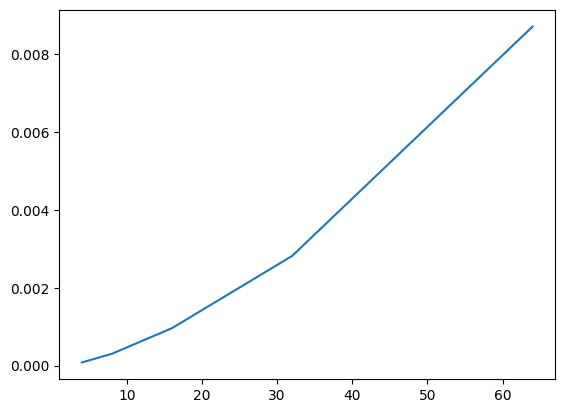

In [50]:
plt.plot(t,f)
plt.show()

### Plusieurs centaines de décimales

In [51]:
z=[128,256,512]
x=mesures1(z)

ValueError: invalid literal for int() with base 10: '000000000000000000000000000000000000000000000000000000000000None'

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

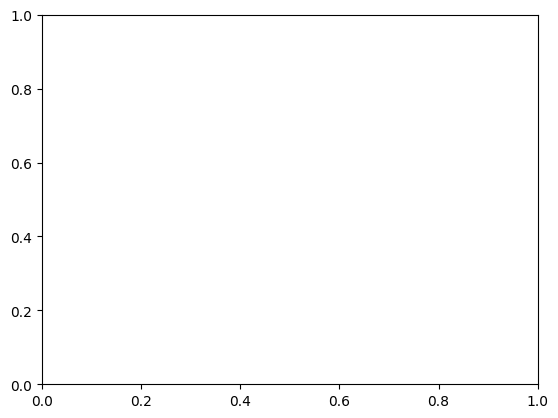

In [52]:
plt.plot(z,x)
plt.show()

### Des milliers de décimales puissances de 2

In [53]:
zz=[1024,2048,4096,8192]
xx=mesures1(zz)

ValueError: invalid literal for int() with base 10: '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [54]:
plt.plot(zz,xx)
plt.show()

NameError: name 'xx' is not defined

## Conclusion intermédiaire

Que conclure ?

En regardant les resulats sur le figures on peut conclure que Karatsuba est lent pour les dizaines de decimales par rapport a l'algorithme naive.Et la complexité augmente avec la taille choisie puisque on a une complexité de O(n^log2(3)).

## Avec GMP

[`gmpy2`](https://gmpy2.readthedocs.io/en/latest/index.html) permet de travailler avec [GMP](http://gmp.org) et de manipuler des entiers arbitrairement longs de type `mpz`.

### `gmpy2.mul()`

On peut raisonnablement supposer qu'un Karatsuba (bien optimisé) est derrière `gmpy2.mul()`, la multiplication de `gmpy2`.
Regardons-ça ...

On se fait la main avec quelques utilisations de cette fonction et les vérifications qui conviennent.

In [55]:
mul(14455,4444)

mpz(64238020)

### Timings

On mesure son efficacité.

In [56]:
def mesures2(n):
    tab=[]
    for i in n:
        u=[randint(0,9) for i in range(i)]
        v=[randint(0,9) for i in range(i)]
        r=intlisttoint(u)
        t=intlisttoint(v)
        avant=time.time()
        mul(r,t)
        apres=time.time()
        temps=apres-avant
        tab.append(temps)
    return tab

In [57]:
zzz=[1024,2048,4096,8192]
xxx=mesures2(zzz)

TypeError: mul() argument type not supported

### Tracés

On traces ces résultats.

In [58]:
plt.plot(zzz,xxx)
plt.show()

NameError: name 'xxx' is not defined

### Observations et conclusion


En conclusion nous pourrons dire que c'est un bon Algorithme de multiplication.Puisque la complexité est presque la moité de la complexité de l'algorithme de karatsuba pour les entiers avec des dizaines de decimales.

## Améliorons notre solution

Il y a 2 pistes à explorer (au moins) pour tenter d'améliorer l'efficacité de notre solution -- sans espérer toutefois rivaliser avec `gmpy2.mul()`.

1. Déterminer (expérimentalement) un seuil d'efficacité de la récursion de Karatsuba et l'exploiter pour une version plus efficace de ce produit. 
    - Ce seuil dépend de notre représentation des "grands entiers" et de notre environnement de calcul.
2. Modifier la représentation actuelle des "grands entiers" et les traitements associés.
    - Cette modification peut être motivée par des contraintes de langage ou par des aspects algorithmiques.
    Nous détaillerons le premier cas le moment venu. Le second cas (choix d'une base de représentation adaptée au format `int` de l'environnement d'exécution) ne sera pas traité dans cette étude. 

### Intégrer le seuil d'efficacité de Karatsuba

Les mesures précédentes permettent d'identifier ce seuil. 
Ecrire une nouvelle version `multKopt` de la multiplication de Karastuba avec seuil.
Effectuer rapidement (avec les tracés adaptés)  une analyse expérimentale de son efficacité.


In [59]:
def multKopt(u: list[int], v: list[int]) -> list[int]:
    x=intlisttoint0(u)
    y=intlisttoint0(v)
    seuil=10
    if len(u)>len(v) :
        u,v=v,u
    if len(u)<=seuil:
        return mult(inttointlist(x),inttointlist(y))
   
    else:
        n=len(u)
        j=n//2
        s=n-j
        s2=s*2
        a=x//(10**j)
        b=x%(10**j)
        c=y//(10**j)
        d=y%(10**j)
        ac=multK0(a,c)
        bd=multK0(b,d)
        aplus=multK0(a+b,c+d)
        A=int(decaler2(str(ac),s2,False))
        B=int(decaler2(str(aplus-ac-bd),s,False))
    
    return inttointlist(A+B+bd)
    

In [60]:
multKopt([1,2,3],[4,5])

[5, 5, 3, 5]

### Une première autre représentation de grands entiers positifs


On va inverser la représentation précédente : un entier positif est maintenant représenté par la liste de ces chiffres (en base 10) stockés dans une liste par ordre **décroissant de son exposant** en notation de position.

Maintenant le chiffre de plus faible exposant est **en début de la liste** qui stocke ses chiffres.

Ainsi $123 = 1 + 2 \times 10 + 3 \times 10^2$  sera représenté par la liste `[3, 2, 1]`. 

On espère que les manipulations de liste qui impactent les chiffres les plus à droite seront moins pénalisantes que si elles étaient effectuées en début de liste.

- On va reprendre les traitements précédents pour les adapter cette nouvelle représentation.
- On se limitera aux fonctions uniquement nécessaires à la multiplication de Karatsuba. 
- Ne pas hésiter à recopier les cellules précédentes et effectuer les modifications pour cette nouvelle représentation de ces différentes fonctions.

### Les nouvelles versions 

Lister et coder les fonctions nécessaires à la multiplication de Karatsuba.

**Notation :** les identifiants de ces fonctions pour la nouvelle représentation seront les précédents suffixées par `2`, _eg._ `inttointlist2()`, ....


In [61]:
def inttointlist2(n):
    A=str(n)
    tab=[]
    for i in reversed(A):
        tab.append(int(i))
    return tab
        

In [62]:
intlisttoint0(inttointlist2(124))


421

### `multK2` : algorithme de Karatsuba, autre version

On peut maintenant écrire cette nouvelle version.

In [63]:
def multK2(u: list[int], v: list[int]) -> list[int]:
    f=u
    g=v
    x=intlisttoint0(u)
    y=intlisttoint0(v)
    seuil=2
    if len(u)<len(v) :
        u,v=v,u
    if len(u)<=seuil:
        return mult(inttointlist(x),inttointlist(y))
   
    else:
        n=len(f)
        j=n//2
        s=n-j
        s2=s*2
        a=f[:j]
        b=f[j:]
        c=g[:j]
        d=g[j:]
        ac=multK2(a,c)
        bd=multK2(b,d)
        aplus=multK2(a+b,c+d)
        z=intlisttoint0(ac)
        w=intlisttoint0(bd)
        q=intlisttoint0(aplus)
        A=decaler(ac,s2)
        B=decaler(inttointlist(q-z-w),s)
        q1=intlisttoint0(A)
        q2=intlisttoint0(B)
        q3=intlisttoint0(bd)
        
    
    return inttointlist(q1+q2+q3)
    

In [64]:
assert multK2([1], [5,6,7]) == inttointlist2(765)
assert multK2([5,6,7], [1]) == inttointlist2(765)
assert multK2([2,2], [1,1]) == inttointlist2(22 * 11)
#assert multK2([6,6,6], [1,1]) == inttointlist2(666 * 11)


RecursionError: maximum recursion depth exceeded while getting the str of an object

### Timings et tracés

On effectue les mesures d'efficacité de cette nouvelle version et les tracés correspondants comme précédemment.

#### Plusieurs centaines de décimales  

In [ ]:
# Timings et tracés
pass

#### Plusieurs milliers de décimales puissances de 2

In [ ]:
# Timings et tracés
pass

#### Prise en compte du seuil

Si les mesures précédentes, le justifie proposer une dernière version `multK2opt()` qui exploite le seuil d'efficacité de la récursion de Karatsuba.


In [ ]:
def multK2opt(u: list[int], v: list[int]) -> list[int]:
    f=u
    g=v
    x=intlisttoint0(u)
    y=intlisttoint0(v)
    seuil=2
    if len(u)>len(v) :
        u,v=v,u
    if len(u)<=seuil:
        return mult(inttointlist(x),inttointlist(y))
   
    else:
        n=len(f)
        j=n//2
        s=n-j
        s2=s*2
        a=f[:j]
        b=f[j:]
        c=g[:j]
        d=g[j:]
        ac=multK2opt(a,c)
        bd=multK2opt(b,d)
        aplus=multK2opt(a+b,c+d)
        z=intlisttoint0(ac)
        w=intlisttoint0(bd)
        q=intlisttoint0(aplus)
        A=decaler(ac,s2)
        B=decaler(inttointlist(q-z-w),s)
        q1=intlisttoint0(A)
        q2=intlisttoint0(B)
        q3=intlisttoint0(bd)
        
    
    return inttointlist(q1+q2+q3)
    

In [ ]:
multK2opt([1,2,4],[2,1,4])

#### Un dernier tracé pour résumer cette partie

## Conclusion